In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-02-04 13:55:15,797 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
results_dir = '../../results/LOO/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
pickle_files

array(['../../results/LOO/A-crossval-swarm_12-005_2018-01-28_07-01-05.pickle',
       '../../results/LOO/A-crossval-swarm_51-009_2018-01-28_08-17-06.pickle',
       '../../results/LOO/A-crossval-swarm_52-001_2018-01-28_08-18-19.pickle',
       '../../results/LOO/B-crossval-swarm_12-005_2018-01-28_08-49-46.pickle',
       '../../results/LOO/B-crossval-swarm_51-009_2018-01-28_19-37-02.pickle',
       '../../results/LOO/B-crossval-swarm_52-001_2018-01-28_19-37-46.pickle',
       '../../results/LOO/C-crossval-swarm_12-005_2018-01-28_08-25-08.pickle',
       '../../results/LOO/C-crossval-swarm_52-001_2018-01-28_20-48-02.pickle',
       '../../results/LOO/D-crossval-swarm_12-005_2018-01-28_08-31-02.pickle',
       '../../results/LOO/D-crossval-swarm_52-001_2018-01-28_20-54-36.pickle'], 
      dtype='<U68')

In [3]:
subjects = ['12-005', '51-009', '52-001']
models = ['A', 'B', 'C', 'D']
assert_params = {
    'amplitude': 2.0,
    'w_scale': 20,
    'w_rot': 0,
    'w_dice': 80
}

In [4]:
def calc_srd(ytyp, params):
    y_true, y_pred = ytyp
    return [p2pspatial.imgproc.srd_loss((yt, yp), w_scale=params['w_scale'],
                                        w_rot=params['w_rot'],
                                        w_dice=params['w_dice'])
            for yt, yp in zip(y_true.iterrows(), y_pred.iterrows())]

In [5]:
loss = {a: {s: None for s in subjects} for a in models}
for file in pickle_files:
    y_test, y_pred, best_params, specifics = pickle.load(open(file, 'rb'))
    for key, value in six.iteritems(assert_params):
        if not np.isclose(specifics[key], value):
            print(key, '=', specifics[key], 'not close to', value)
            assert False
    n_folds = specifics['n_folds']
    assert len(y_pred) == n_folds
    assert len(y_test) == n_folds
    assert len(best_params) == n_folds
    model = specifics['modelname']
    subject = specifics['subject']
    if model not in models:
        print('Model %s found, skip.' % model)
        continue
    if subject not in subjects:
        print('Subject %s found, skip.' % subject)
        continue
    print('Processing Model %s, Subject %s' % (model, subject))
    
    func_params = {'w_scale': 0, 'w_rot': 0, 'w_dice': 100}
    thisloss = p2pu.parfor(calc_srd, zip(y_test, y_pred), func_args=[func_params])
    loss[model][subject] = [item for sublist in thisloss for item in sublist]

Processing Model A, Subject 12-005
Processing Model A, Subject 51-009
Processing Model A, Subject 52-001
Processing Model B, Subject 12-005
Processing Model B, Subject 51-009
Processing Model B, Subject 52-001
Processing Model C, Subject 12-005
Processing Model C, Subject 52-001
Processing Model D, Subject 12-005
Processing Model D, Subject 52-001


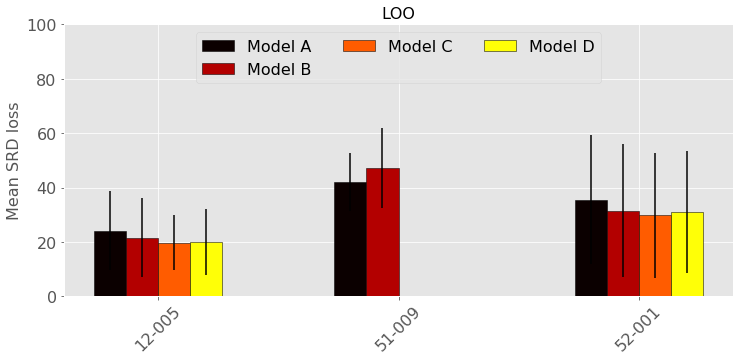

In [6]:
N = len(subjects)
width = 0.4 / N
ind = np.arange(N)

fig, ax = plt.subplots(figsize=(12, 5))
cm = plt.get_cmap('hot')

rects = {}
for m, model in enumerate(models):
    for s, subject in enumerate(subjects):
        if not loss[model][subject]:
            continue
        r = ax.bar(s + m * width, np.mean(loss[model][subject]), 
                   width, yerr=np.std(loss[model][subject]), 
                   color=cm(m / len(models)), edgecolor='k', 
                   label='Model %s' % model)
        rects[model] = r[0]
ax.set_xticks(ind + (len(rects) - 1) / 2 * width)
ax.set_xticklabels(subjects, rotation=45, ha='center', fontsize=16)
ax.legend([rects[m] for m in models if m in rects],
          ['Model ' + m for m in models if m in rects], 
          ncol=3, loc='upper center', fontsize=16)
allvals = [[item for sublist in filter(None, loss[m].values())
            for item in sublist]
           for m in models]
maxheight = max([item for sublist in allvals for item in sublist])
ax.set_ylim(0, np.ceil(maxheight / 20) * 20)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_ylabel('Mean SRD loss', fontsize=16)
ax.set_title(os.path.basename(os.path.dirname(results_dir)), fontsize=16)
fig.savefig(os.path.join(results_dir, 'srd_loss.png'))